<a id="0"></a> <br>
 # Table of Contents  

- Part 0:  [Project Introduction](#1)
- Part 1:  [Exploratory Data Analysis (EDA)](#2)   
  - 1.1  [Import Files, assisgn source directories, and Load Data](#3)
  - 1.2  [Use partial of training data for EDA](#4)
  - 1.3  [Abnormal images in all data ](#5)
- Part 2:  [Model Building and training](#6)
  - 2.1 [Copy all normal images to directories, with train test split](#7)
  - 2.2 [Baseline model](#8)
  - 2.3 [Model Tuning 1 - Add more epochs to increase training AUC](#9)
  - 2.4 [Model Tuning 2 - Add Model Complexity Attempt 1(Use Transfer Learning)](#10)
- Part 3: [Test Results](#11)
- Part 3: [Project Conclusion](#12)
- [References](#13)


# <a id="1"></a>
<div style="text-align: center; background-color: #AFDDCE; font-size:100%; padding: 5px;border-radius:10px 10px;">
    <h1>Part 0: Project Introduction </h1>
</div>

### Dataset Overview
- The dataset originates from a Kaggle project focused on classifying small pathology images. While the information on data collection methods is not clear, the [dataset description](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) provides valuable insights and clarification on duplicates. 
- The dataset comprises separate directories for train and test images. Ground truth labels are available in the "train_labels.csv" file, where a positive label signifies the presence of tumor tissue in the center 32x32px region.
- Although the exact dataset size is undisclosed (we'll discover in EDA), it is mentioned that duplicates were removed. The dataset maintains the same splits as the PCam benchmark.

### Project Goals and focus
- Project goal: Identify metastatic tissue in histopathologic scans of lymph node sections in the unseen (testing) dataset.
- Beyond Prediction: Gain insights and identify potential bottlenecks/challenges into the application of CNNs for processing and analyzing medical images in large volume. 


### Model Training Approach:
- Initial Base Run: A preliminary model was trained to establish a baseline.
- Tuning: Refinements were made, focusing on epoch numbers as the model was still learning.
- Transfer Learning: Utilized InceptionV3 for improved performance.

### A few highlights:
- EDA (Exploratory Data Analysis): Due to the dataset's size, a subset (1%) was used for efficient EDA. Noteworthy patterns and abnormal images were identified and excluded from training.
- Data Handling: Numpy arrays were employed for faster EDA, but image copies were later used for model training.
- Model Training Steps: A systematic approach involved an initial base run, tuning parameters, and implementing transfer learning with InceptionV3.


# <a id="2"></a>
<div style="text-align: center; background-color: #AFDDCE; font-size:100%; padding: 5px;border-radius:10px 10px;">
    <h1>Part 1: Exploratory Data Analysis (EDA)</h1>
</div>

# <a id="3"></a>

<div style="text-align: center; background-color: #81badd; font-size:70%; padding: 2px;border-radius:10px;">
    <h2>Part 1.1: Import Files, assisgn source directories, and Load Data</h2>
</div>

In [1]:
# Import Libraries
# Generaal
import numpy as np
import pandas as pd
import os
import shutil
from glob import glob 
import cv2
import gc 
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve,auc,recall_score, precision_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay


%matplotlib inline


# Tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import InceptionV3, DenseNet121, NASNetMobile
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook,trange


2024-02-05 21:53:25.699746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 21:53:25.699899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 21:53:25.875812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Assign directory 
base_dir = '../input/histopathologic-cancer-detection'  #path
label_path = os.path.join(base_dir, 'train_labels.csv')
train_path = os.path.join(base_dir,'train')
test_path = os.path.join(base_dir,'test')
sample_path = os.path.join(base_dir,'sample_submission.csv')

In [3]:
# Check numbers of files under train and test
print('samples in training data: ',len(os.listdir(train_path)))
print('samples in testingdata: ',len(os.listdir(test_path)))

samples in training data:  220025
samples in testingdata:  57458


In [4]:
# create a data frame to match training data image id and labels
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) # get image id to merge with training labels
train_labels = pd.read_csv(label_path)
df = df.merge(train_labels, on = "id") # merge labels and filepaths
df.head(2) 

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0


In [5]:
# check if df is created correctly
# check image counts
print('df shape',df.shape)
# check null values
print('nulls :',df.isnull().sum().sum())
# check dup values
print("dups: ",df.duplicated().sum())

df shape (220025, 3)
nulls : 0
dups:  0


Positive labels in traing data:  0.40503124644926713


Text(0.5, 1.0, 'Label Distributions in 220025 training data')

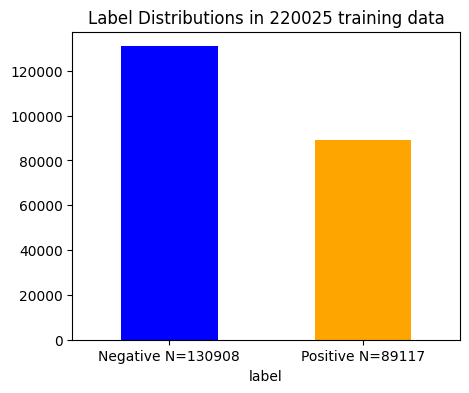

In [6]:
# Plot the label count histogram
print('Positive labels in traing data: ', train_labels['label'].value_counts()[1] /  (train_labels['label'].value_counts()[0] + train_labels['label'].value_counts()[1])  )
plt.figure(figsize=(5, 4))
ax = train_labels['label'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.xticks([0, 1], labels=[f"Negative N={train_labels['label'].value_counts()[0]}", f"Positive N={train_labels['label'].value_counts()[1]}"], rotation=0)
plt.title(f'Label Distributions in {train_labels.shape[0]} training data')


# <a id="4"></a>

<div style="text-align: center; background-color: #81badd; font-size:70%; padding: 2px;border-radius:10px;">
    <h2>Part 1.2: Use partial of training data for EDA</h2>
</div>

In [7]:
# train_labels.head()
df.head()

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/histopathologic-cancer-detection/trai...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/histopathologic-cancer-detection/trai...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/histopathologic-cancer-detection/trai...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1


#### Here for partial EDA data, I convert images to numpy array with unit8 types. It's faster.
* Note creating numpy array with huge data takes too much memory, which would cause problems when reach the stage of training deeper CNN. Need to copy files to directory for training later.

In [9]:
# source https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93. 
# This method is fast but consumes too much memory. casue later I cannot train deep CNN 
# function to load data.

def load_data(pct, df):
    """This function loads percent of df and return image path/name and labels."""
    # Get the number of images to load
    n = int(pct * df.shape[0])
    
    # Randomly select n indices from the dataframe
    random_indices =  np.random.choice(df.shape[0], size=n, replace=False)
    
    # Allocate a numpy array for the images (n, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([n, 96, 96, 3], dtype=np.uint8)
    # Convert the labels to a numpy array
    y = np.squeeze(df['label'].values)[random_indices]

    # Read images using randomly selected indices
    for i, idx in enumerate(random_indices):
        X[i] = cv2.imread(df.loc[idx, 'path'])

    return n, X, y


#### Slow to load data each time. Just use 1% training data for EDA seems enough.

In [10]:
# Load partical data
PCT = 0.01
n,sample_X,sample_y = load_data(pct = PCT, df=df)

In [11]:
# Take a look at image size and pixel info
print('Image shape: ',sample_X.shape)
print('Image maximum pixel value: ', sample_X.max())
print('Image minimum pixel value: ', sample_X.min())

Image shape:  (2200, 96, 96, 3)
Image maximum pixel value:  255
Image minimum pixel value:  0


In [12]:
# source: https://www.kaggle.com/code/qitvision/a-complete-ml-pipeline-fast-ai
# read image with flipping to rgb for visualization purpose
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

In [13]:
def plot_images(index, num_image_each):
    '''
    num_image_each needs to be an integer number >= 2
    '''
    fig, ax = plt.subplots(1, num_image_each, figsize=(20, 4))

    for i, idx in enumerate(index):
        path = os.path.join(train_path, train_labels.iloc[idx]['id'])
        ax[i].imshow(readImage(path + '.tif'))

    ax[0].set_ylabel('samples', size='large')
    
    plt.show()

random negative index:  [138982 211144  29399 168635 203272  34838 170647  36334]
random positive index:  [ 16217 191351 115745 196435 132919 109578 133985 179546]

plot some negative images


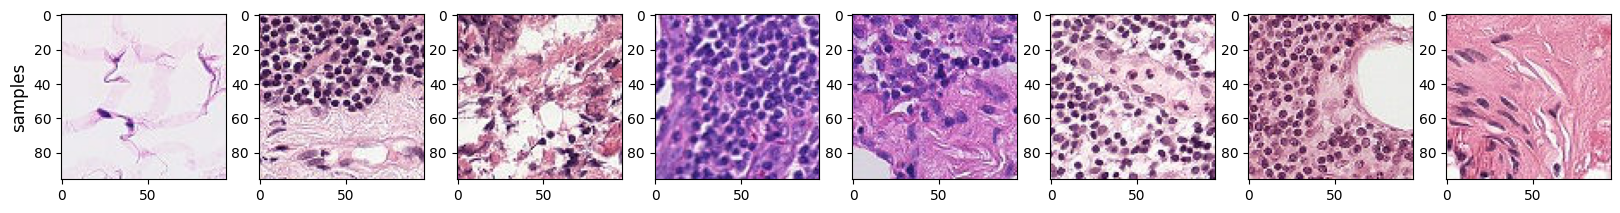


plot some positive images


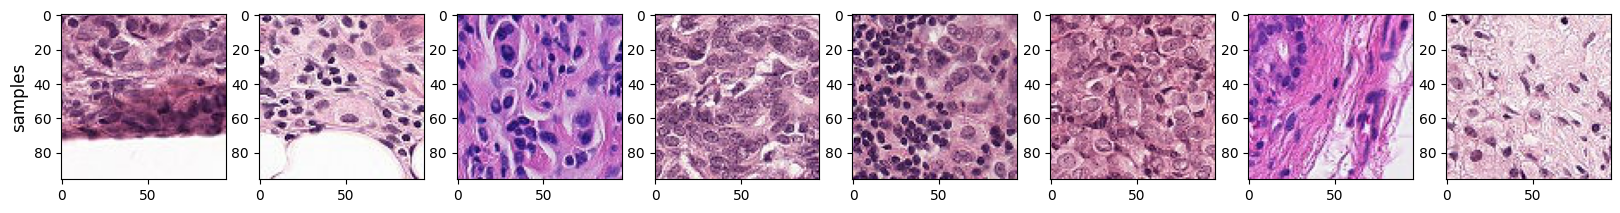

In [14]:
# plot some random negative and positive images  

# number of positive or negative each
num_image_each = 8

# Index of postive and negative samples
index_negative = np.random.choice(train_labels[train_labels['label']==0].index,num_image_each)
index_positive = np.random.choice(train_labels[train_labels['label']==1].index,num_image_each)
print("random negative index: ", index_negative)
print("random positive index: ", index_positive)

# Plot some negatives images
print("\nplot some negative images")
plot_images(index= index_negative, num_image_each=num_image_each)

# Plot some positive images
print("\nplot some positive images")
plot_images(index= index_positive, num_image_each=num_image_each)

#### Context Knowledge:
According to [Libre Pathology](https://librepathology.org/wiki/Lymph_node_metastasis), **these features might help us to identify tumor tissue** under microscopic:


- +/-Cells with cytologic features of malignancy.
  - Nuclear pleomorphism (variation in size, shape and staining).
  - Nuclear atypia:
    - Nuclear enlargement.
    - Irregular nuclear membrane.
    - Irregular chromatin pattern, esp. asymmetry.
    - Large or irregular nucleolus.
  - Abundant mitotic figures.

Wikipedia for [H&E stain ](https://en.wikipedia.org/wiki/H%26E_stain)

#### Draw some plots to see distributions of pixels in different color chanels for positive and negative examples

In [15]:
# seperate positive and negaive sample and get means
pos_samples = sample_X[sample_y == 1]
neg_samples = sample_X[sample_y == 0]

# means brightness of positive and negative samples
pos_sample_avgs=np.mean(pos_samples, axis=(1,2,3))
neg_sample_avgs=np.mean(neg_samples, axis=(1,2,3))

# max brightness of positive and negative samples
pos_sample_maxs=np.max(pos_samples, axis=(1,2,3))
neg_sample_maxs=np.max(neg_samples, axis=(1,2,3))

# min brightness of positive and negative samples
pos_sample_mins=np.min(pos_samples, axis=(1,2,3))
neg_sample_mins=np.min(neg_samples, axis=(1,2,3))

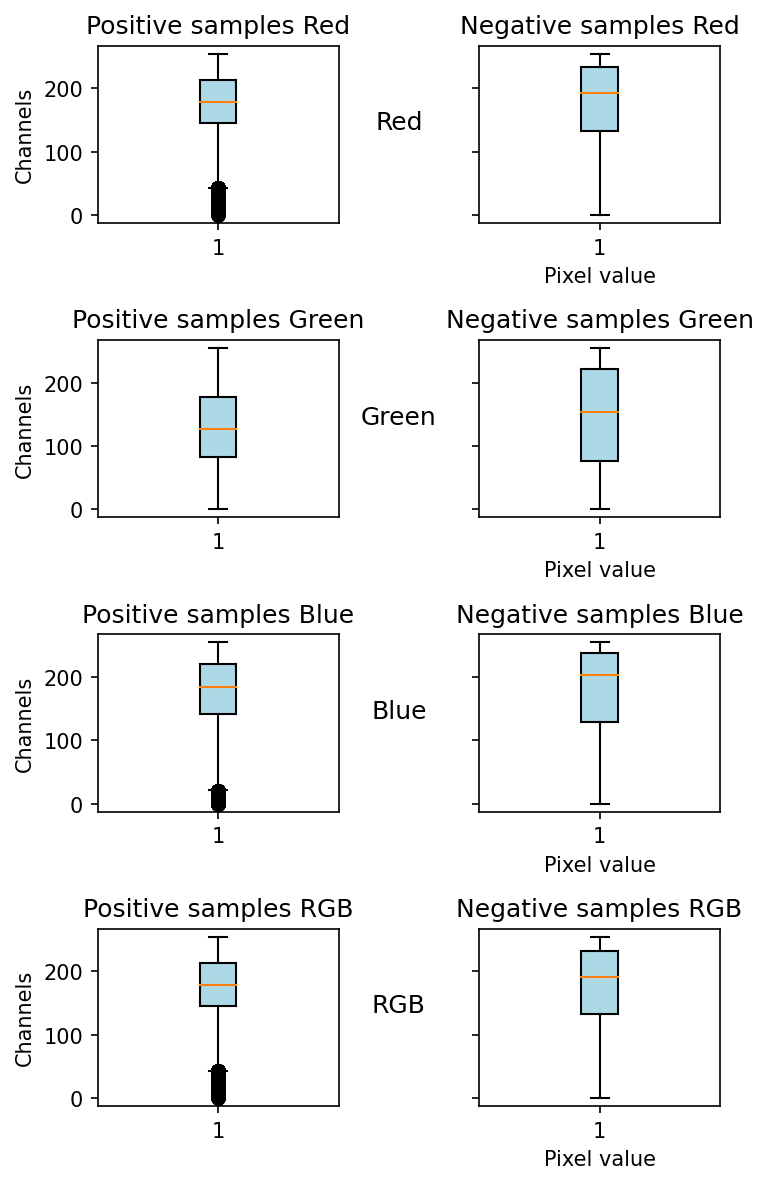

In [16]:
# plot box plots for positive and negative sample chanel distributions
channels = ["Red", "Green", "Blue", "RGB"]
sample_types = ["Positive", "Negative"]
samples = [pos_samples, neg_samples]

fig, axs = plt.subplots(4, 2, sharey=True, figsize=(5, 8), dpi=150)

for i, channel in enumerate(channels):
    for j, sample_type in enumerate(sample_types):
        # Get the corresponding samples
        current_samples = samples[j]

        # Create filled box plot (vertically)
        bp = axs[i, j].boxplot(current_samples[:, :, :, i % 3].flatten(), vert=True, patch_artist=True)
        axs[i, j].set_title(f"{sample_type} samples {channel}")

        # Set box color
        colors = ['lightblue', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Set y-axis label for the last column
        if j == 1:
            axs[i, j].set_ylabel(channel, rotation='horizontal', labelpad=35, fontsize=12)

# Set common labels
for i in range(4):
    axs[i, 0].set_ylabel("Channels")
    axs[i, 1].set_xlabel("Pixel value")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

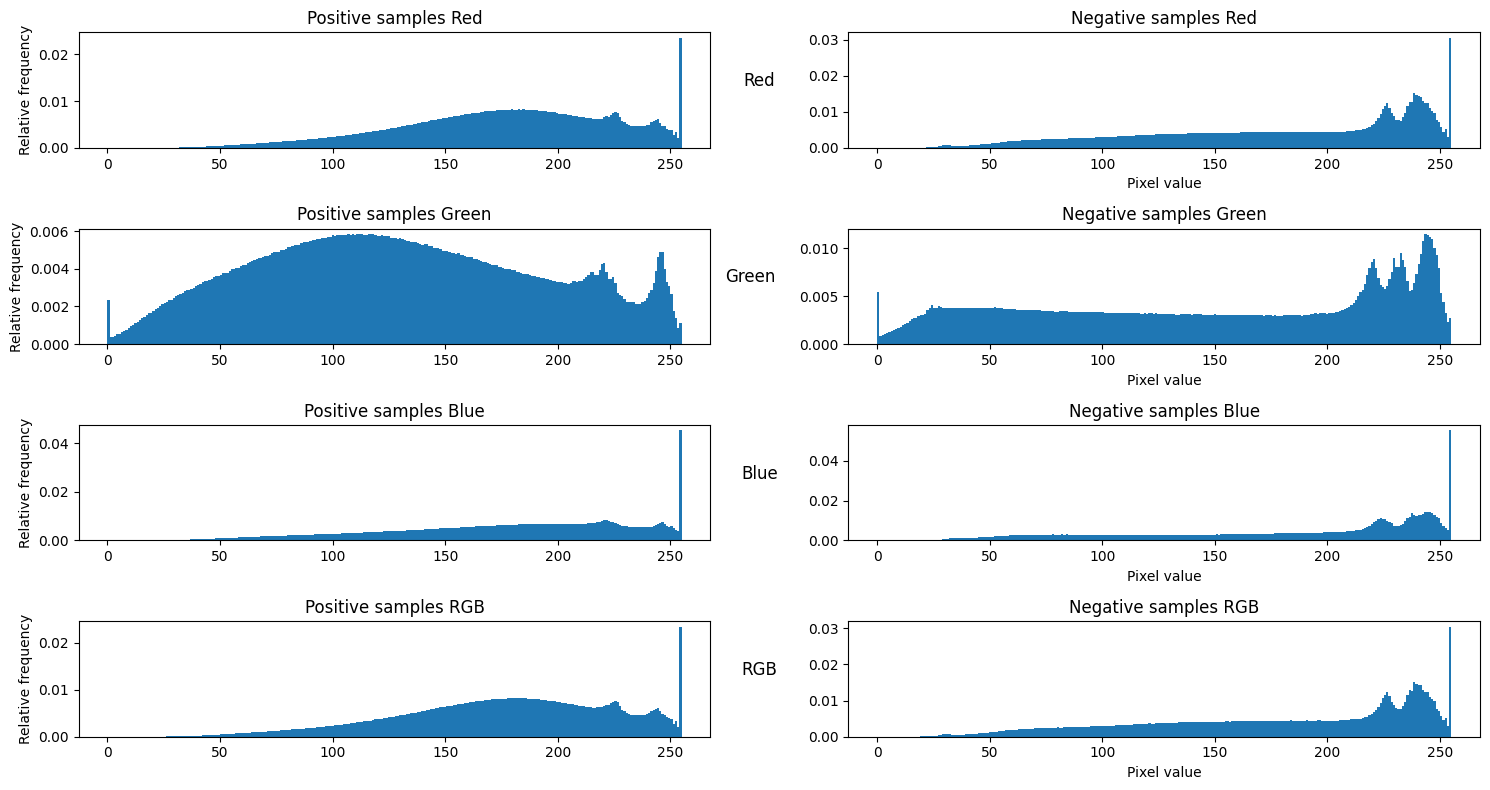

In [17]:
# plot histograms for positive and negative sample chanel distributions
nr_of_bins = 256
channels = ["Red", "Green", "Blue", "RGB"]
sample_types = ["Positive", "Negative"]
samples = [pos_samples, neg_samples]

fig, axs = plt.subplots(4, 2, figsize=(15, 8))

for i, channel in enumerate(channels):
    for j, sample_type in enumerate(sample_types):
        # Get the corresponding samples
        current_samples = samples[j]

        # Create histogram
        axs[i, j].hist(current_samples[:, :, :, i % 3].flatten(), bins=nr_of_bins, density=True)
        axs[i, j].set_title(f"{sample_type} samples {channel}")

        # Set y-axis label for the last column
        if j == 1:
            axs[i, j].set_ylabel(channel, rotation='horizontal', labelpad=35, fontsize=12)

# Set common labels
for i in range(4):
    axs[i, 0].set_ylabel("Relative frequency")
    axs[i, 1].set_xlabel("Pixel value")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


Text(0, 0.5, 'Relative frequency')

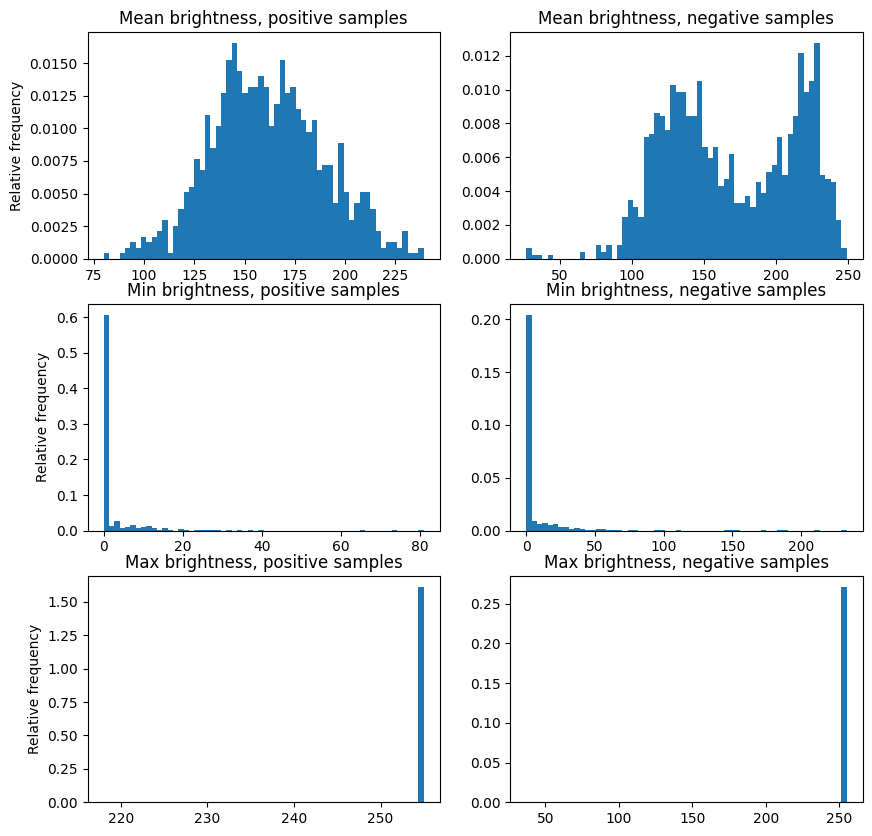

In [18]:
# Plot mean,min,max brightness histograms for positive and negative samples
fig,axs = plt.subplots(3,2,figsize=(10, 10))
axs[0,0].hist(pos_sample_avgs,bins= 60,density=True);
axs[0,1].hist(neg_sample_avgs,bins= 60,density=True);
axs[0,0].set_title("Mean brightness, positive samples");
axs[0,1].set_title("Mean brightness, negative samples");
axs[0,0].set_ylabel("Relative frequency")

axs[1,0].hist(pos_sample_mins,bins= 60,density=True);
axs[1,1].hist(neg_sample_mins,bins= 60,density=True);
axs[1,0].set_title("Min brightness, positive samples");
axs[1,1].set_title("Min brightness, negative samples");
axs[1,0].set_ylabel("Relative frequency")

axs[2,0].hist(pos_sample_maxs,bins= 60,density=True);
axs[2,1].hist(neg_sample_maxs,bins= 60,density=True);
axs[2,0].set_title("Max brightness, positive samples");
axs[2,1].set_title("Max brightness, negative samples");
axs[2,0].set_ylabel("Relative frequency")


##### Note the threshold below I found after image inspection. Since those codes are comment out, I just want to show some abnormal pictures here is samples.

In [19]:
# Calculate brightness for each image. 
brightest_values = np.max(sample_X, axis=(1, 2, 3))
darkest_values = np.min(sample_X, axis=(1, 2, 3))

# Find indices of images with abnormal brightness
# Note the threshold I found after later abnormal image inspectaion on all images.
abnormal_brightness_indices_sx = np.where(
    (brightest_values < 75) | (darkest_values  >  180)
)[0]


print( 'abnormal_indices in sample X: ',abnormal_brightness_indices_sx)
print( 'number of abnormal_indices in sample X: ',abnormal_brightness_indices_sx.shape[0])

abnormal_indices in sample X:  [  61  301  385  467  815  901 1805 1961]
number of abnormal_indices in sample X:  8


Image 61 brightest pixel value is 255, darkest pixel value is 189
Image 301 brightest pixel value is 45, darkest pixel value is 13
Image 385 brightest pixel value is 250, darkest pixel value is 185
Image 467 brightest pixel value is 47, darkest pixel value is 24
Image 815 brightest pixel value is 236, darkest pixel value is 210
Image 901 brightest pixel value is 54, darkest pixel value is 21
Image 1805 brightest pixel value is 249, darkest pixel value is 233
Image 1961 brightest pixel value is 37, darkest pixel value is 21


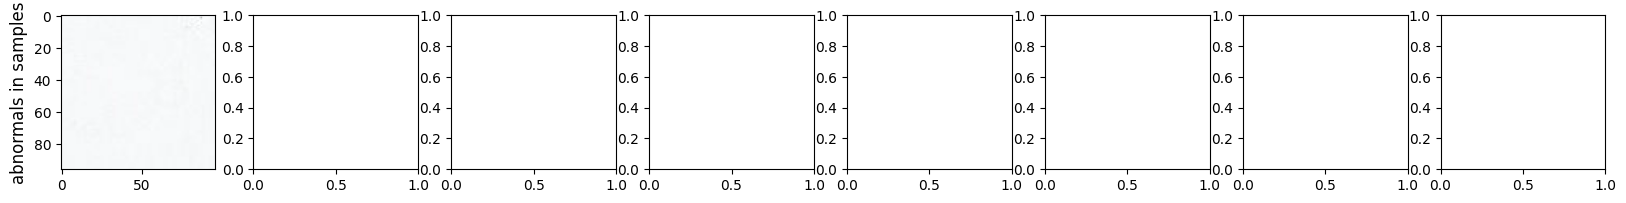

In [20]:
# check brightest and darkest pixel of abnormal images in samples
for index in abnormal_brightness_indices_sx: 
    print(f'Image {index} brightest pixel value is {np.max(sample_X[index,:,:,:])}, darkest pixel value is {np.min(sample_X[index,:,:,:])}')
   
# Plot abnormal images in samples
fig, ax = plt.subplots(1, len(abnormal_brightness_indices_sx), figsize=(2.5 * len(abnormal_brightness_indices_sx) , 2))

for i, idx in enumerate(abnormal_brightness_indices_sx):
    ax[i].imshow(sample_X[idx,:,:,:])
    ax[0].set_ylabel('abnormals in samples', size='large')
    plt.show()

<div style="background-color: #FFF2CC; padding: 10px;">
<span style="font-size: larger;">

### What I've found during EDA:
    
- There are **220,025 samples** in training data and **57,458** samples in testing data. 
- **Train/Test split: 80%/20%**.
- There are **130,908 negative and 89,117 postitive labels.  Positive lable %: 41%**.
- **Images has shape (96, 96, 3)**
- **Pixal values range from 0 to 255**. 
- **Negative samples seems to have more brighter (200-250 higer value) pixels in red, green, blue, and RGB mixed chanels**.
- **There are a few abnormal images**. Some image's smallest pixel values seems high, meaning they are too bright. Also, maybe a few images are too dark.
    
### Few Data preprocessing/clearning idea based on EDA:
- For now, I don't plan to do further resampling to balance data. 40% positive samples using AUC seems okay. We are required to use AUC for this project. AUC isn't too sensitive to imbalanced dataset unless data is extremely imbalanced.
- Normalize data using /.255. I will do this in image augmentation though.
- Do some further inspectation on abnormal images. Then, exclude those abnormal images when copy all data to directories for training. 
    

# <a id="5"></a>

<div style="text-align: center; background-color: #81badd; font-size:70%; padding: 2px;border-radius:10px;">
    <h2>Part 1.3 Abnormal images in all data </h2>
</div>

### Abnormal brightness image inspection

* Note I commented codes below out because those takes lots of RAM to include in final run.

In [21]:
# Load all data
# st =time.time()
# PCT = 1
# n,X,y = load_data(pct = PCT, df=df)
# print(time.time() - st)

In [22]:
# Get and save abnormal indices
# Calculate brightness for each image
# brightest_values = np.max(X, axis=(1, 2, 3))
# darkest_values = np.min(X, axis=(1, 2, 3))

# # Find indices of images with abnormal brightness
# abnormal_brightness_indices = np.where(
#     (brightest_values < 75) | (darkest_values  >  180)
# )[0]

# print('Labels:', y[abnormal_brightness_indices])
# print( 'number_of_abnormal_indices: ',abnormal_brightness_indices.shape[0])
# np.save('/kaggle/working/abnormal_brightness_indices.npy', abnormal_brightness_indices)

In [23]:
# indices_string = f'abnormal_brightness_indices = {abnormal_brightness_indices.tolist()}'
# print(indices_string)

In [24]:
# get abonormal indices (hard-coded to avoid re-run unecessary codes)

abnormal_brightness_indices = [563, 1184, 1501, 2000, 2817, 3872, 4067, 4079, 4204, 4382, 4660, 5190, 5636, 6520, 6907, 7012, 7063, 7173, 8134, 8325, 8406, 8525, 9010, 9307, 9390, 9415, 9764, 9832, 10200, 10337, 11326, 11915, 12771, 12965, 13724, 13781, 13801, 13945, 14335, 14742, 16689, 16899, 17809, 18386, 18613, 18743, 18810, 18842, 19022, 19336, 19456, 19579, 20019, 20243, 20294, 20687, 21713, 21844, 22923, 23084, 23135, 23263, 23306, 23396, 23429, 23962, 25503, 25930, 25966, 26266, 26758, 26771, 27134, 27188, 27888, 28005, 29274, 30035, 30323, 30481, 30754, 31352, 32016, 32212, 32230, 33071, 33392, 33946, 34005, 34921, 35086, 35763, 35875, 36062, 36452, 36614, 36760, 36881, 37404, 37613, 37645, 37842, 38089, 38117, 38127, 38387, 38412, 38414, 39151, 39191, 40038, 40084, 40884, 41171, 41442, 41749, 41753, 42940, 43235, 43236, 43370, 43526, 43561, 43689, 43818, 44236, 45707, 46058, 47419, 48056, 48270, 49635, 49889, 50295, 50638, 51614, 52251, 53086, 53427, 53976, 54446, 54638, 54699, 54990, 55000, 55351, 55515, 56591, 56675, 57504, 57552, 57674, 58043, 58090, 58625, 58835, 59690, 59823, 61334, 61379, 61784, 61857, 62393, 62534, 62926, 62935, 63407, 63672, 65585, 66062, 66656, 66741, 66927, 67452, 67502, 67903, 68159, 68220, 68583, 68607, 68709, 69071, 71056, 72897, 72979, 73372, 73666, 73822, 74334, 74386, 74536, 74573, 74953, 75278, 75379, 75745, 75963, 76168, 76746, 76841, 77341, 78310, 78668, 78798, 79156, 79894, 80524, 81094, 81098, 81320, 81358, 81408, 82393, 82518, 82852, 82945, 83303, 83354, 83393, 83479, 83559, 83651, 84554, 84670, 84843, 85021, 85154, 85329, 85503, 86727, 87077, 87873, 87961, 88128, 88459, 88581, 89759, 89969, 90442, 90585, 91986, 92803, 93235, 93709, 94200, 94521, 95061, 95276, 95387, 95468, 95530, 95583, 95713, 95749, 96035, 96640, 96929, 98927, 99296, 99298, 99458, 99806, 99927, 100380, 100402, 100605, 100872, 101543, 102082, 102620, 102621, 102712, 102983, 104141, 104192, 104290, 104634, 104948, 105141, 105326, 106057, 106439, 106867, 106929, 107026, 107212, 107304, 107776, 107990, 108110, 108674, 108920, 109101, 109393, 110252, 110412, 111151, 112387, 112620, 112621, 113174, 113192, 113553, 114720, 114790, 114829, 115397, 115582, 116799, 117191, 117287, 117913, 118377, 118507, 118610, 118776, 118841, 119605, 119616, 119789, 120325, 120532, 121005, 121226, 121275, 121380, 121631, 122261, 122391, 122864, 123934, 124240, 124444, 124626, 125824, 126393, 126487, 126969, 127079, 127196, 127335, 127460, 128059, 128263, 128451, 128973, 129338, 129416, 129806, 130123, 130194, 130257, 130390, 130754, 131060, 131557, 131992, 132402, 132404, 132812, 133154, 133211, 133297, 134614, 134666, 135599, 135615, 135963, 136110, 136477, 137134, 137851, 137963, 138273, 138381, 138484, 138859, 139331, 139744, 139817, 139920, 140298, 140399, 141505, 142139, 142468, 142889, 143209, 143309, 143518, 144010, 144265, 144534, 145298, 145955, 146020, 146522, 147783, 147952, 148527, 148545, 149393, 150294, 150759, 151089, 152243, 152549, 152837, 153256, 153651, 154094, 154133, 154238, 154270, 154316, 154729, 155536, 155865, 156253, 156422, 156512, 157071, 157228, 157581, 158455, 158705, 158929, 159130, 159801, 160097, 160480, 160588, 161045, 161076, 161195, 161303, 161308, 161379, 161443, 162186, 162323, 162487, 162796, 162797, 163116, 163449, 163932, 164002, 164046, 164052, 164077, 164803, 164944, 165394, 166311, 166593, 167008, 167058, 167767, 167825, 167864, 167871, 168099, 168270, 168456, 168649, 168791, 168916, 168965, 169061, 169068, 169210, 169227, 169355, 169583, 169903, 169976, 169981, 171091, 171456, 171564, 171975, 172152, 172427, 172437, 172764, 172930, 173665, 174007, 176035, 176314, 176474, 176507, 176653, 177333, 177629, 177955, 178367, 178552, 179100, 179995, 180425, 180441, 180761, 181059, 181208, 181280, 181376, 181591, 181871, 181964, 182028, 182140, 182439, 182459, 182777, 182788, 182858, 183068, 183462, 183901, 185126, 185474, 185743, 185935, 186136, 186217, 186687, 187048, 187650, 188092, 188603, 188964, 188981, 189406, 189854, 190096, 190141, 190482, 190589, 190899, 190913, 191313, 191407, 191684, 191902, 191908, 192341, 192456, 192477, 192569, 193074, 193194, 193618, 193623, 193840, 193844, 193879, 194220, 194275, 195125, 196150, 196775, 197231, 197234, 198170, 198226, 198325, 198356, 199282, 199308, 199634, 200032, 200286, 201505, 201625, 201990, 202078, 202103, 202167, 203077, 203493, 203656, 203741, 204340, 204405, 204624, 205096, 205142, 205274, 205585, 205687, 205721, 206409, 207278, 207917, 208118, 208354, 208505, 209273, 209725, 210278, 210915, 211026, 211056, 211398, 211546, 211585, 212253, 212672, 212872, 212923, 213383, 213575, 213581, 213944, 214139, 214809, 214824, 215062, 215389, 216153, 216309, 216557, 216759, 217036, 217188, 217258, 217345, 217380, 217563, 217685, 217993, 218102, 218511, 219449, 219534, 219598]



In [25]:
#  Plot some abnormal images
# fig, ax = plt.subplots(1, 10, figsize=(30, 4))

# for i, idx in enumerate(abnormal_brightness_indices[11:21]):
#     ax[i].imshow(X[idx, :, :, :])
#     ax[0].set_ylabel('samples', size='large')
# plt.show()

#### During the inspectations above, I found that if the brightest pixel is less than 75 or the darkest pixel is greater than 180, the images are basically blank. We should remove them.



# <a id="6"></a>
<div style="text-align: center; background-color: #AFDDCE; font-size:100%; padding: 5px;border-radius:10px 10px;">
    <h1>Part 2: Model Building and training</h1>
</div>

# <a id="7"></a>

<div style="text-align: center; background-color: #81badd; font-size:70%; padding: 2px;border-radius:10px;">
    <h2>Part 2.1: Copy all normal images to directories, with train test split</h2>
</div>

#### Now let's load all (but only normal data) in. Copy files to directories takes a longer time (compared to copy to int8 numpy array)but can save more memory for later model training.



In [26]:
# drop abnormal images indices in df
df.drop(abnormal_brightness_indices, inplace=True)
print('df size after removing abnormal images: ', df.shape[0])

df size after removing abnormal images:  219387


In [27]:
# train test split
df_train, df_val = train_test_split(df, test_size=0.10, random_state=100)

In [28]:
# reset index using id
df.set_index('id', inplace=True)


In [29]:
# Create directories for model augmentation
work_dir ='/kaggle/working/data'
train_dir =os.path.join(work_dir,'train')
val_dir=os.path.join(work_dir,'val')

if os.path.exists(work_dir):# remove the entire directory and its contents if already exist
    shutil.rmtree(work_dir)

for fold in [train_dir, val_dir]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf)) # this will create necessary parent directories as well :)       

In [30]:
# Copy all files to train and validation directies
 
# copy train files 
for id in df_train['id'].values:
    fn =id +'.tif'
    label = str(df.loc[id,'label']) 
    source_dir_fn=os.path.join(train_path, fn)
    train_dir_fn=os.path.join(train_dir,label,fn)
    shutil.copyfile(source_dir_fn,train_dir_fn )
    
# copy validation files
for id in df_val['id'].values:
    fn =id +'.tif'
    label = str(df.loc[id,'label']) 
    source_dir_fn =os.path.join(train_path, fn)
    val_dir_fn =os.path.join(val_dir,label,fn)
    shutil.copyfile(source_dir_fn,val_dir_fn )

In [31]:
# check image counts in Training and validation directories

#Training
print('Positive images in training directory: ', len(os.listdir(os.path.join(train_dir, '1'))))
print('Negative images in training directory: ',len(os.listdir(os.path.join(train_dir, '0'))))
print('% Positive images in training directory: ',len(os.listdir(os.path.join(train_dir, '1'))) / (len(os.listdir(os.path.join(train_dir, '0'))) + len(os.listdir(os.path.join(train_dir, '1'))) ),'\n')

# Validation
print('Positive images in validation directory: ', len(os.listdir(os.path.join(val_dir, '1'))))
print('Negative images in validation directory: ',len(os.listdir(os.path.join(val_dir, '0'))))
print('% Positive images in validation directory: ',len(os.listdir(os.path.join(val_dir, '1'))) / (len(os.listdir(os.path.join(val_dir, '0'))) + len(os.listdir(os.path.join(val_dir, '1'))) ), '\n')

# Training vs. Validation
print('Images in Training directory: ', len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0'))) )
print('Images in  validation directory: ', len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0'))) )
print('% Training images: ', (len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0')))) / (len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0')))+len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0'))) )    )
print('\nTotal images: ',  (len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0')))+len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0'))) )    )


Positive images in training directory:  80194
Negative images in training directory:  117254
% Positive images in training directory:  0.406152505976257 

Positive images in validation directory:  8902
Negative images in validation directory:  13037
% Positive images in validation directory:  0.40576142941793153 

Images in Training directory:  197448
Images in  validation directory:  21939
% Training images:  0.8999986325534329

Total images:  219387


In [32]:
# Collect garbage to free up memory
del pos_samples 
del neg_samples 
del pos_sample_avgs 
del neg_sample_avgs 
del pos_sample_mins
del neg_sample_mins 
del pos_sample_maxs 
del neg_sample_maxs
del df
gc.collect()

142603

# <a id="8"></a>

<div style="text-align: center; background-color: #81badd; font-size:70%; padding: 2px;border-radius:10px;">
    <h2>Part 2.2: Baseline model</h2>
</div>

### First I will just try to build a baseline model that I think might perform well. A few helpful knowledges. 👇



<div style="background-color: #FCFFE9; padding: 10px;">
    
### Why CNN for images?📝
  - **Problem caused by the big images data** (Even more and more pixels nowadays!)
    - **Computation capacity**: consider the weights we need for flattening out all the pixels and use them as the first layer of a fully connected neural network!
    - **Overfit**: Fully-connected neural network would have too many parameters. Lots of weights from empty spaces in the image aren't useful and they are redundant.
  - **Translational Invariance in images**
    - Fully connected layer would think an object shift to a different position is a different object beacause it learns the whole image.
    - CNN uses small and different sized filters to learn/detect different primitive features (Ex: an ear, an eye, intensity of color, texture, shape, orientation)in an image. **What a filter learn in one position of an image can be re-used in other positions.** CNN slices those filters across the image and the **learning weights are shared** in different positions. This results in way less parameters/overfitting/waste of computational resources

### Why multiple convolution layers? 📝
There is a **field of view (FOV)** effect of CNN. Here is an example:
- 1st convolution filter of size 3 * 3 would look at the input image 3 * 3 at a time and assign it to 1 output pixal. That is, each size 1 pixal in the 1st convolution feature map gets it's information from an area of 3 * 3 in the original input image. 3 * 3 isn't big area, so the 1st filter can only detect local features like lines etc.
- 2nd convolution filter of size 3 * 3 would look at the 1st convolution feature map image 3 * 3 at a time and assign it to 1 output pixal. That is, each size 1 pixal in the 2nd convolution feature map gets it's information from an area of size 3 * 3 in the 1st convolution feature map image. That is equivalent to look at an area of 9 * 9 from the original image ( (3 * 3) * (3 * 3)) based on layer 1. So, 2nd convolution layers can see more global features.
- The FOV becomes larger when CNN gets more layers so CNN would see more global feature in later layers. For example:
  - Layer 1 may detect features like edges and lines, color contrasts, textures, etc.
  - Layer 2 may detect simple shapes and patterns formed by the combination of features from the first layer. like curves,combinations of edges, corners, and textures.
  - Later layers may detect more global features like eyes, face, cars, etc. <br>
 
(More details of FOV in [this paper](https://arxiv.org/abs/1311.2901))
    
 ### Why prefer small filters? 📝

Nowadays small filters (like 3 * 3 )are more popular:

- **Computation effeciency**: for instance, two 3 * 3 filters and one 5 * 5 filter both get you (N - 4) * (N -4) feature map. But the 3 * 3 filters only need 18 (=3 * 3 * 2) but 5 * 5 filter need 25 (5 * 5) parameters. 
- Deal with **Translational Invariance in images** better

 ### Why use 1 * 1 Filters? 📝
    
-  1 * 1 filters mimic applying a fully-connected layer to each pixals. This adds non-linearity to let layer learn more complex function.(Details in [this video](https://www.youtube.com/watch?v=c1RBQzKsDCk&list=PLpFsSf5Dm-pd5d3rjNtIXUHT-v7bdaEIe&index=115)). To illustrate: 
   - If we have a 6 * 6 * 32 (depth) input layer. At each slice step, a 1 * 1 filter would take 32 numbers (depth), multiply each 32 numbers by 32 weights, apply activation function (maybe Relu), then output 1 output units. This is like creating one neuron of a fully connected layer .
   - So, each 1 * 1 filter would output a 6 * 6 * 32 input layer to 6 * 6 feature map. With more filters, the output would be 6 * 6 * number of filters. Thus, adding more filters is like creating more output neuron units.
- 1 * 1 filters allow to shrink or add number of channels. Can be used for computation efficiency.  
    
### Why use Pooling layer? 📝

    
- Pooling layer in CNN uses subsampling method to **down-sample the spatial dimensions of the input feature maps**. 
- A **pooling filter of size p would usualy reduce the input image size by 1/p** (without considering the input image depth, which goes to 1 for each filter). Explaination:
    - Output_image_size Output_image_size = (N + 2 * p - f)/s +1 (N: input image size; p: padding size; f: filter size; s: stride size)
    - Pooling filter typically don't have padding. (p=0)
    - The pooling window is usually applied to non-overlapping regions of the input. (So,usually s=f.)
    - To illustrate, if we have a 10 * 10 image and a 2*2 pooling filter, the output size would be (10-2)/2+1 = 5. 
- Pooling filter sizes are **usually 2 * 2** or some **even size** (while **convolution filters are often odd size**), so usually it reduce half of the image size  
- Two popular types:
   - **Max pooling**: the maximum is taken within each region. For example, if the input image has a deepth of 3 and we have a 2*2 max pooling filter. The output pixal for each step would be the maximum of the 12 numbers (12=2 * 2 * 3). It emphasize the most dominant features in local regions and is used most often.
   - **Average pooling**: the average is taken within each region. It provides a smoother down-sampling effect.


    
- Why using pooling layer? - It shrinks down the feature map size for a few reasons:
  - **Computational efficiency**
  - Helps to see more **global features**
  - **Feature generalization**: retain most important information and ignore the details. The layer would be less sensitive to small shifts in the input.


### My Plan for training the model
- Reduce Training Error:
  - First focus on reducing training error, which means it's comprehensive and complex enough that it fits training data well. 
- Reduce Validation Error:
  - Once satisfied with the training performance, introduce overfitting prevention techniques:
    - Dropout
    - L2 or L1 normalization
    - Batch normalization (might just add it earlier to reduce training error)
    - Data Augmentation
- Attempt of Transfer Learning:
  - After just a couple of attempts, if the model is still too simple, explore transfer learning with pre-trained models.
  - Include structures for overfitting from the start

Note: I've decided to withhold result submission until I'm thoroughly satisfied with my validation score (probably not until the last run😅). Given that the testing score is unlikely to significantly surpass the validation one, I'm prioritizing efficient use of resources. However, I will meticulously analyze each model's performance, conducting a detailed comparison of training and validation metrics. This analysis is crucial for guiding the next steps in training direction.


## Model 1 
* note I comment out the code and left with train/validation AUC and loss plots. I don't want to run those too many times to save time. 

In [33]:
# Build model 1
# Note for model 1 to model 3, I used copied numpy data. I later found this method consumes too much memory.
# mymodel_1 = tf.keras.models.Sequential([
#    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
#    Conv2D(32, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
#    Conv2D(64, (3, 3), activation='relu'),
#    Conv2D(64, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
#    Conv2D(128, (3, 3), activation='relu'),
#    Conv2D(128, (3, 3), activation='relu'),
#    MaxPooling2D((2, 2)),
#    Conv2D(128, (1, 1), activation='relu'),
#    Flatten(),
#    Dense(128, activation='relu'),
#    Dense(128, activation='relu'),
#    Dense(1, activation='sigmoid')
# ])

# Model summary
#mymodel_1.summary()

In [34]:
# compile model 1

# Define the learning rate schedule (exponential decay)
# initial_learning_rate = 0.001
# decay_steps = 1000 # total steps = (training size/batchsize) * number of epochs, 200,000/64*3= around 10000
# decay_rate = 0.9
# lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# base_model.compile(
#     optimizer=Adam(learning_rate= lr_schedule),
#     loss='binary_crossentropy',
#     metrics=[AUC()]
# )


In [35]:
# Fit model 1
# datagen = ImageDataGenerator(rescale=1.0 / 255.0)
# train_generator = datagen.flow(X_train, y_train, batch_size=64)
# val_generator = datagen.flow(X_val, y_val, batch_size=64)
# mymodel_1.fit(train_generator, validation_data=val_generator, epochs=10, batch_size=64, verbose=2)


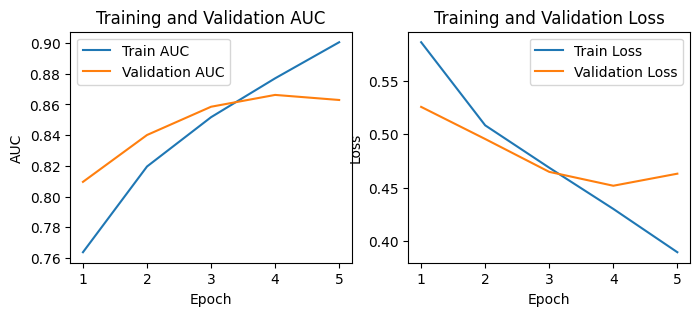

In [36]:
# Plot model 1 results

# train, validation auc history from '.history' 
# harded so I only run it once. I can't run multiple tuning or I will be out of RAM/GPU :(

model1_history_auc=     [0.7638, 0.8196, 0.8517, 0.8770, 0.9005]
model1_history_auc_val= [0.8096, 0.8401, 0.8585, 0.8662, 0.8629]

model1_history_loss=         [0.5863, 0.5084, 0.4687, 0.4301, 0.3895]
model1_history_loss_val=     [0.5257, 0.4956, 0.4648, 0.4518, 0.4631 ]

# history = mymodel_1.fit(X_train/255., y_train, validation_data=(X_val/255., y_val), epochs=5, batch_size=64, verbose=2)

# Plot training and validation AUC
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
# plt.plot(history.history['auc'], label='Train AUC')
# plt.plot(history.history['val_auc'], label='Validation AUC')
plt.plot(range(1, 6),model1_history_auc, label='Train AUC')
plt.plot(range(1, 6),model1_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 6),model1_history_loss, label='Train Loss')
plt.plot(range(1, 6),model1_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



### Model 1 Performance:
- Achieved 0.9 training AUC after 5 epochs, potential for further improvement.
- Validation AUC dipped after 4 epochs, indicating possible overfitting.

### Tuning Plan:
- Extend training to assess if the model's complexity is adequate.
- Monitor validation AUC to ensure generalization performance.


# <a id="9"></a>

<div style="text-align: center; background-color: #81badd; font-size:70%; padding: 2px;border-radius:10px;">
    <h2>Part 2.3: Model Tuning 1 - Add more epochs to increase training AUC </h2>
</div>

## Model 2 - add more epochs (train longer)
* note I comment out the code and left with train/validation AUC and loss plots. I don't want to run those too many times to save time. 

In [37]:
# Build model 2
# Note for model 1 to model 3, I used copied numpy data. I later found this method consumes too much memory.
mymodel_2 = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (1, 1), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# model summary
mymodel_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         
 g2D)                                                   

In [38]:
# compile model 2

# Define the learning rate schedule (exponential decay)
# initial_learning_rate = 0.001
# decay_steps = 1000 # total steps = (training size/batchsize) * number of epochs, 200,000/batch size*epochs
# decay_rate = 0.8
# lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# mymodel_2.compile(
#     optimizer=Adam(learning_rate= lr_schedule),
#     loss='binary_crossentropy',
#     metrics=[AUC()]
# )


In [39]:
# fit model 2
# datagen = ImageDataGenerator(rescale=1.0 / 255.0)
# train_generator = datagen.flow(X_train, y_train, batch_size=48)
# val_generator = datagen.flow(X_val, y_val, batch_size=48)
# mymodel_2.fit(train_generator, validation_data=val_generator, epochs=8, batch_size=48, verbose=2)


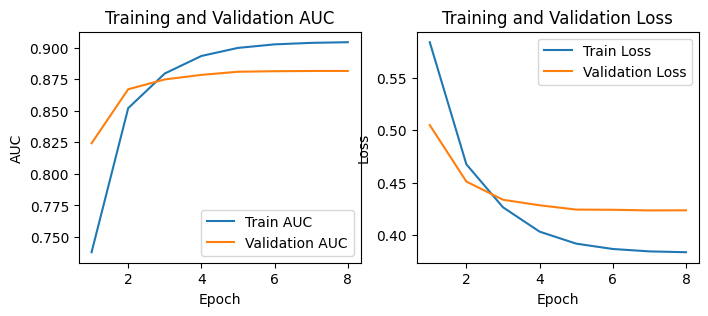

In [40]:
# Plot model 2 results

# train, validation auc history from '.history' 
# hard coded so I only run it once. I can't run multiple tuning or I will be out of RAM/GPU :(

model2_history_auc=     [0.7379, 0.8521, 0.8796, 0.8935, 0.8999, 0.9027, 0.9039, 0.9044]
model2_history_auc_val= [0.8243, 0.8671, 0.8749, 0.8785, 0.8810, 0.8814, 0.8816, 0.8816]

model2_history_loss=         [0.5842, 0.4674, 0.4263, 0.4030, 0.3915, 0.3864, 0.3841,0.3833]
model2_history_loss_val=     [0.5049, 0.4509, 0.4335, 0.4282, 0.4241, 0.4239, 0.4233,0.4234 ]

# history = mymodel_1.fit(X_train/255., y_train, validation_data=(X_val/255., y_val), epochs=5, batch_size=64, verbose=2)

# Plot training and validation AUC
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
# plt.plot(history.history['auc'], label='Train AUC')
# plt.plot(history.history['val_auc'], label='Validation AUC')
plt.plot(range(1, 9), model2_history_auc, label='Train AUC')
plt.plot(range(1, 9), model2_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 9),model2_history_loss, label='Train Loss')
plt.plot(range(1, 9),model2_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Model 2 Performance:
- Model 2's training AUC is around 0.9, suggesting that extending training duration may not enhance performance. This indicates a potential need for increased model complexity.

### Tuning Plan:
- Address the complexity issue. Two approaches:
  - Update Model Structure:
    - Add more layers, filters, or neurons.
    - Add batch normalization or other architectural enhancements.
  - Transfer Learning:
    - Using a pretrained model known for its complexity and broad training data. Note that success may vary based on data differences and training set size.
    - For learning purpose, I will prioritize transfer learning as an initial step for learning purposes.
    - If transfer learning falls short, revert to enhancing model complexity with additional layers and features.


A few things about transfer learning 👇 and a great [artile](https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625) to read

# <a id="10"></a>

<div style="text-align: center; background-color: #81badd; font-size:70%; padding: 2px;border-radius:10px;">
    <h2>Part 2.3: Model Tuning 2 - Add Model Complexity Attempt 1 (Use Transfer Learning) </h2>
</div>

<div style="background-color: #FCFFE9; padding: 10px;">
    
## Transfer Learning

#### Why transfer learning and how to use it?
    
If dataset is very large, it can easily take more than a few weeks to train. It's good to use transfer learning in this case. A few ways to use it:
- **As fixed feature extractor**: froze the weights in the convoluntion layers. Can add/train fully connected layers.
- **Fine-tuning the CNN**: you data is big, similar to the transfer learning dataset but not exactly the same. You can 'de-forze' and train some CNN layers weights too.
- **Use only part of CNN layer**: add a few of your own CNN layers also.
  - A typical example for medical images.
    - **Medical images** are harder to collect and even harder to label since they need to labeled by doctors.
    - Trained by big ImageNet data, the first few layers can find some primitive features that can be used for medical images. We can use the earlier layers and add some later layers to train specifically for medical images.
   
    
    
#### When to use a pre-trained network?
- **❌New dataset is small (ex: 20,000 with 100 categories) and similar to the original dataset (ex: 2,000,000 with 1000 categories)**
    - Since the network is huge, you have froze the weight, which means you aren't training the model. Even not consider computation resource that you can actually re-train the model, the model is going to overfit since it's too big and more suitable for much bigger data.
    
- **✅New dataset is large and similar to the original dataset**
    - can gain training time by using either fixed or fresh weights
- **❌New dataset is small but very different from the original dataset**
    - Overfit as in case in. Additionally, if very different, the transfer learning efficiency would be low.
- **✅New dataset is large and very different from the original dataset**
    - Can still use part of feature extractor of earlier layers. Still can save lots of training time.
    
Various [models](https://keras.io/applications/) pre-trained on ImageNet.

<div style="background-color: #FCFFE9; padding: 10px;">
    
## InceptionV3 
#### Insights from InceptionV3 Architecture:
- Lower Layers:
  - Basic convolutional Operations: such as Conv2d_1a_3x3, Conv2d_2a_3x3, and Conv2d_2b_3x3 
  - Fundamental local features extractraction: such as edges, textures, colors, and gradients
  - Simple Shapes and Contrast: In addition to low-level features, identify simple shapes and capturing contrast variations in the images.
- Intermediate Layers:
  - Mixed Operations:  blocks such as Mixed_3a, Mixed_4a, and Mixed_5a, combining different filter sizes and operations in parallel.
  - Repetitive Structures capturing: such as repetitive structures within the images, recognizing patterns that repeat across the dataset.
  - Color Variations and Relationships: further understand color variations and establish hierarchical relationships between different parts of objects in the images.
  - Object Boundaries: delineating object boundaries, enhancing the model's ability to recognize distinct objects and their spatial relationships.
- Deeper Inception Blocks:
  - Mixed Operations: Blocks such as Mixed_5b, Mixed_6a, Mixed_7a
  - Complex Shapes and Structures: improved understanding of complex shapes and intricate structures present in the images.
  - Discrimination of Patterns: enhanced discrimination of complex patterns, distinguish fine-grained details and textures.

#### My Adaptation Plan:
- Feature Extraction:
  - Utilize earlier blocks for low-level features 
- Intermediate Layers Modification:
  - Introduce extra convolution layers for medical image nuances.
  - Post 'mixed2' layer in InceptionV3, the feature map is roughly (9 * 9). Add padding to prevent rapid size reduction (retain spatial information)
- Enhancements with 1x1 Filters:
  - Incorporate 1x1 filters for improved learning.
- Handle Overfitting:
  - Batch normalization
  - Dropout layers.
- Image Augmentations for better generalization.

## Model 3 - transfer learning with Inception V3

In [41]:
# Build model 3
# Note for model 1 to model 3, I used copied numpy data. I later found this method consumes too much memory.

# Load the InceptionV3 model
incept_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the weights of the layers.
for layer in incept_model.layers:
    layer.trainable = False

# get the last_layer of inception we want to use
last_layer = incept_model.get_layer('mixed2')
print('last layer output shape: ', last_layer.output_shape)

# Create a new model using the functional API
base_model = Model(inputs=incept_model.input, outputs=last_layer.output)

# Add layers to the model
mymodel_3 = Sequential([
    base_model,
    
    Conv2D(64, (3, 3), padding='same', activation='relu'), # keep the width and height
    BatchNormalization(),
    Conv2D(64, (1, 1),activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),            
    Conv2D(64, (1, 1), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

# Print the model summary
mymodel_3.build(input_shape=(None, 96, 96, 3))
mymodel_3.summary()

87910968/87910968 [==============================] - 3s 0us/step
last layer output shape:  (None, 9, 9, 288)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 9, 9, 288)         993056    
                                                                 
 conv2d_101 (Conv2D)         (None, 9, 9, 64)          165952    
                                                                 
 batch_normalization_94 (Ba  (None, 9, 9, 64)          256       
 tchNormalization)                                               
                                                                 
 conv2d_102 (Conv2D)         (None, 9, 9, 64)          4160      
                                                                 
 batch_normalization_95 (Ba  (None, 9, 9, 64)          256       
 tchNormalization)                                               
           

In [42]:
# compile model 3

#Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9 
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compile the model
mymodel_3.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=[AUC()]
)

In [43]:
# Fit model 3
BATCH_SIZE = 32
EPOCHS = 10

# data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
)

datagen_val = ImageDataGenerator(
    rescale=1./255,
)

train_generator = datagen.flow_from_directory(directory=train_dir,
                                            batch_size=BATCH_SIZE,
                                            class_mode='binary',
                                            target_size=(96, 96))

val_generator = datagen_val.flow_from_directory(directory=val_dir, 
                                                batch_size=BATCH_SIZE, 
                                                class_mode='binary',
                                               target_size=(96,96))

steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)

# Fit model 3
history_3 = mymodel_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Found 197448 images belonging to 2 classes.
Found 21939 images belonging to 2 classes.
Epoch 1/10
6171/6171 [==============================] - 1634s 264ms/step - loss: 0.3366 - auc: 0.9250 - val_loss: 0.2652 - val_auc: 0.9587
Epoch 2/10
6171/6171 [==============================] - 1655s 268ms/step - loss: 0.2793 - auc: 0.9480 - val_loss: 0.2447 - val_auc: 0.9641
Epoch 3/10
6171/6171 [==============================] - 1635s 265ms/step - loss: 0.2571 - auc: 0.9557 - val_loss: 0.2900 - val_auc: 0.9654
Epoch 4/10
6171/6171 [==============================] - 1628s 264ms/step - loss: 0.2432 - auc: 0.9604 - val_loss: 0.2413 - val_auc: 0.9696
Epoch 5/10
6171/6171 [==============================] - 1621s 263ms/step - loss: 0.2353 - auc: 0.9629 - val_loss: 0.2371 - val_auc: 0.9702
Epoch 6/10
6171/6171 [==============================] - 1616s 262ms/step - loss: 0.2315 - auc: 0.9641 - val_loss: 0.2271 - val_auc: 0.9708
Epoch 7/10
6171/6171 [==============================] - 1611s 261ms/step - loss

KeyError: 'auc_11'

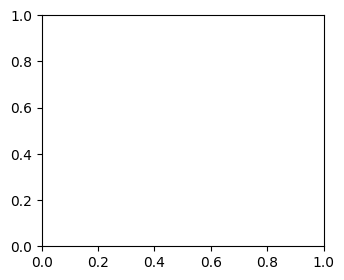

In [44]:
# Plot metrics
epochs = np.arange(1, EPOCHS+1)
plt.figure(figsize=(8, 3))

# AUC
plt.subplot(1, 2, 1)
plt.plot(epochs, history_3.history['auc_11'], label='Train')
plt.plot(epochs, history_3.history['val_auc_11'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC Over Epochs')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_3.history['loss'], label='Train')
plt.plot(epochs, history_3.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()


### Model 3 Performance:
- Achieved satisfactory training AUC of around 0.96 and a commendable validation AUC of 0.97 in the last epoch.
- validation AUC plateaued after 8 epochs.

### Next Steps:
- Model evaluation, focusing on metrics such as precision, recall, F1 score, and confusion matrix to gain a holistic understanding of the model's performance. This approach ensures a balanced assessment of the model's predictive capabilities beyond AUC, providing insights into its precision, recall, and overall classification effectiveness.

In [ ]:
# Predict validation set 
samples_val = len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0')))
val_generator_for_pred = datagen_val.flow_from_directory(directory=val_dir, 
                                                batch_size=1, 
                                                class_mode='binary',
                                               target_size=(96,96),
                                                shuffle=False)


val_predictions = mymodel_3.predict_generator(val_generator_for_pred,steps=samples_val, verbose=1)


In [ ]:
# Actual vs. predicted classes for validation set

# actual
val_labels = val_generator_for_pred.classes

# convert probability to classes using 0.5 shreshold
binary_val_predictions = (val_predictions > 0.5).astype(int)


In [ ]:
# Plot ROC curve

# Calculate AUC
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)
roc_auc = auc(fpr, tpr)

# Plot 
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Get recall, predicision, F1, accuracy scores for validation set
recall = recall_score(val_labels, binary_val_predictions)
precision = precision_score(val_labels, binary_val_predictions)
F1 = f1_score(val_labels, binary_val_predictions)
acc= accuracy_score(val_labels, binary_val_predictions)

print("Recall on validation set:", recall)
print("Precision on validation set:", precision)
print("F1 score n on validation set:", F1)
print("Accuracy score n on validation set:", acc)

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(val_labels, binary_val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-cancer', 'Cancer'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

### Final Model Reflection:

- Recall Concerns:
  - Recall around 85% is suboptimal for cancer detection is a bit low.
  - 1350+ cancer images misclassified as non-cancer signals a notable false-negative rate.
- Importance of Recall:
  - High recall crucial in cancer detection.

- Future Considerations:
  - Boosting recall through class weight adjustment or model fine-tuning. Emphasizes the need to strike a balance between overall model performance and sensitivity in critical scenarios like cancer detection.

# <a id="11"></a>
<div style="text-align: center; background-color: #AFDDCE; font-size:100%; padding: 5px;border-radius:10px 10px;">
    <h1>Part 3: Test Results </h1>
</div>

In [ ]:
# Copy files to test_dir

# Directories
test_source_path = os.path.join(base_dir,'test')
test_images = os.listdir(test_path)
test_dir=os.path.join(work_dir,'test')
test_dir_images=os.path.join(test_dir,'Pos and neg images') # put all images directly to work_dir won't work! Need to put images under a folder in test_dir 

# remove the entire directory and its contents if already exist
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
# Make directories   
os.makedirs(test_dir)
os.makedirs(test_dir_images)

# Copy images
for fn in test_images:
    source_fns = os.path.join(test_source_path, fn)
    test_fns = os.path.join(test_dir_images, fn)
    shutil.copyfile(source_fns,test_fns)



In [ ]:
# Check number of images under test dir
print(len(os.listdir(test_dir)))
print(len(os.listdir(test_source_path)))

In [ ]:
# Test data generator
datagen_test = ImageDataGenerator(
    rescale=1./255)

test_generator = datagen_test.flow_from_directory(directory=test_dir, 
                                                batch_size= BATCH_SIZE, 
                                                class_mode=None,
                                               target_size=(96,96),
                                                shuffle=False)

test_predictions = mymodel_3.predict(test_generator, verbose=1)

In [ ]:
# Create test df
test_df= pd.DataFrame({'id':  test_generator.filenames,'label': test_predictions.flatten()})
test_df.head(1)

### The id for submission should not have '.tif'

In [ ]:
# Source https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing
# Get rid of '.tif' in 'id' column
def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

test_df['id'] = test_df['id'].apply(extract_id)

test_df.head()

In [ ]:
# submition
test_df.to_csv('CNN submission.csv', index=False)

In [ ]:
# remove files in test_dir to prevent error
shutil.rmtree(test_dir)

### Testing AUC after submission🙌:
- Score: 0.9334
- Private score: 0.9361

### Thoughts on testing AUC:
  - There is a notable gap exists between testing AUC (around 0.93) and validation AUC (around 0.97). Possible Explanations and improvement tips:   
    - Overfitting Issues: The discrepancy may indicate lingering overfitting concerns. Increasing augmentation and dropout might help.
    - Validation Set Size: The validation set size at 10% might be limiting. Expanding it could provide a more representative evaluation of model generalization.
    - AUC as Metric:  AUC, while a powerful metric, introduces complexities during model compilation, as it considers performance across all thresholds. In contrast, practical evaluation metrics like recall, precision, and the confusion matrix often rely on a fixed threshold, typically set at 0.5. Using another metric might help.

 


### Model Tuning Progress and Performance Comparison summary:

- Model 1:

  - Utilized 3 blocks of 2 convolutions followed by 1 max pooling structure.
  - Achieved a training AUC of 0.90 and a validation AUC of 0.86.
  - Training for 5 epochs revealed potential for further improvement.

- Model 2:

  - Retained Model 1 structure but extended training duration.
  - Training AUC remained unchanged, while validation AUC increased to 0.88.
  - Indicated that the initial model structure was too simplistic.
- Model 3 (Transfer Learning):
  - Employed Transfer Learning, significantly increasing model complexity and addressed overfitting problem at the same time.
  - Demonstrated substantial improvement, elevating validation AUC from 0.88 to an impressive 0.97, and training AUC from 0.90 to 0.96.

# <a id="12"></a>
<div style="text-align: center; background-color: #AFDDCE; font-size:100%; padding: 5px;border-radius:10px 10px;">
    <h1>Part 3: Project Conclusion </h1>
</div>

### Conclusion and take aways
In the course of this project, I gained valuable insights into leveraging Convolutional Neural Networks (CNNs) for medical image cancer detection. Several noteworthy takeaways:
- Data Handling Challenges: Managing large datasets can be challenging. I explored various methods for efficient data loading, such as converting images to int8 numpy arrays. However, this approach proved memory-intensive, impacting model training.
- Transfer Learning Impact: The adoption of transfer learning significantly elevated the model's complexity. Also, transfer learning model is usually trained on a more diverse and larger dataset,this infusion of external knowledge could empower the model to discern intricate patterns in medical images. Moreover, transfer Learning could address overfitting problems at the same time.
- Considerations for Model Evaluation: AUC, while a powerful metric, introduces complexities during model compilation, as it considers performance across all thresholds. In contrast, practical evaluation metrics like recall, precision, and the confusion matrix often rely on a fixed threshold, typically set at 0.5.

### Future Improvements:

- Exploring Alternative Metrics: Experimenting with alternative metrics, such as accuracy, could provide a different perspective on model performance. However, achieving a balanced dataset would be crucial in this context.

- Optimizing Region of Interest: Focusing on the central 32x32 region, where cancer detection is most relevant, may involve cropping images to enhance model efficiency and effectiveness.
- Addressing testing AUC discrepancy:
  - Experimenting with increased augmentation and dropout techniques to reduce overfitting.
  - Consider expanding the validation set size for a more representative evaluation of model generalization.



# <a id="13"></a>

## References (really helpful notebooks🙏🏽)
https://www.kaggle.com/code/jieshends2020/baseline-keras-cnn-roc-fast-10min-0-925-lb/edit<br>
https://www.kaggle.com/code/akarshu121/cancer-detection-with-cnn-for-beginners<br>
https://www.kaggle.com/code/qitvision/a-complete-ml-pipeline-fast-ai<br>
https://www.kaggle.com/code/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb<br>
https://www.kaggle.com/code/suicaokhoailang/wip-densenet121-baseline-with-fastai<br>
https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing<br>
